In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from varname import nameof
import scipy.stats as s
import statsmodels.api as sm
import plotly.io as pio
pio.renderers.default = "svg"

# Statistical tools and turbulence scales

## First exercise

On the last homework we have explored the time series related to the measurements of the wind flow in atmospheric boundary layer over two different canopies (Cerrado and  Eucalyptus). We will use those data again to explore some turbulence properties of the both situations

In [2]:
df_cerrado_raw = pd.read_excel("Data Eddy Covariance Cerrado.xlsx", header = 1)
df_eucalyptus_raw = pd.read_excel("Data Eddy Covariance Eucalyptus.xlsx", header = 1)

In [3]:
df_cerrado = df_cerrado_raw.drop([0,1]).reset_index(drop=True)[0:36000]
df_eucalyptus = df_eucalyptus_raw.drop([0,1]).reset_index(drop=True)[0:36000]

In [4]:
units = {}
for variable in df_cerrado:
    units[variable] = df_cerrado[variable][0]

In [5]:
df_cerrado["Time"] = np.arange(0, len(df_cerrado)/10, 0.1).round(2).tolist()
df_eucalyptus["Time"] = np.arange(0, len(df_eucalyptus)/10, 0.1).round(2).tolist()

## Second exercise

The  wind  tunnel  of  the  Laboratory  of  Energy  and  Environment  of  UnB  is  an important facility to study air flow to different devices (in particular to the study of hydrokinetic turbines). The free-flow Ux data were obtained from a record of our  hot-wire anemometry system. It is available in the file free_flow.txt(in our UnB-Aprender3 space). Repeat the same steps of the last exercise for this new data. (Contact Rafael Mendes for the experiments details).

In [6]:
df_unb = pd.read_csv('free_flow_data.txt', index_col=False, names = ["U"])

In [7]:
def calibrate(series):
    p1 = -0.2615 
    p2 = 3.4829 
    p3 = -15.6308
    p4 = 34.5537
    p5 = -27.5652
    return p1*(series**4) + p2*(series**3) + p3*(series**2) + p4*series + p5

In [8]:
df_unb["Time"] = np.arange(0, len(df_unb)/10000, 0.0001).round(2).tolist()

### Using the velocity components Ux and Uy, compute the instantaneous velocity vector aligned to the main wind direction;

In [9]:
def projection_vector(source, target):

    target_norm = np.sqrt(sum(target**2))    
    proj_of_source_on_target = (np.dot(source, target)/target_norm**2)*target

    return proj_of_source_on_target

In [10]:
for df in [df_cerrado, df_eucalyptus]:
    
    Uxy = []
    main_flow_direction_xy = np.array([df_cerrado["Ux"].mean(), df_cerrado["Uy"].mean()])
    for measurement_x, measurement_y in zip(df["Ux"], df["Uy"]):
        measurement_direction = np.array([measurement_x, measurement_y])
        projected_Ux, projected_Uy = projection_vector(measurement_direction, main_flow_direction_xy)
        if projected_Ux >= 0 and projected_Uy >= 0:
            Uxy.append((((projected_Ux**2)+(projected_Uy**2))**(1/2)))
        else:
            Uxy.append(-(((projected_Ux**2)+(projected_Uy**2))**(1/2)))
            
    df["Uxy"] = Uxy
    df["Ux'"] = df["Ux"] - df["Ux"].mean()
    df["Uy'"] = df["Uy"] - df["Uy"].mean()
    df["Uxy'"] = df["Uxy"] - df["Uxy"].mean()
    df["U'"] = ((df["Ux'"]**2)+(df["Uy'"]**2))**(1/2)
    df["KE"] = (((df["Ux'"]**2).mean())+((df["Uy'"]**2).mean()))**(1/2)
    
for df in [df_unb]:
    df["U'"] = df["U"] - df["U"].mean()

In [11]:
df_unb.head()

,U,Time,U'
0,7.015309,0.0,0.056525
1,7.132053,0.0,0.173270
2,6.998719,0.0,0.039936
3,7.015309,0.0,0.056525
4,6.982151,0.0,0.023368


In [12]:
raw_data_figs = {}
for key_name, df in zip(["Cerrado", "Eucalyptus"], [df_cerrado, df_eucalyptus]):
    for variable in ["Uxy"]:
        raw_data_figs["{}_{}".format(key_name,variable)] = px.line(df, x="Time", y=variable, title=key_name, template="simple_white")
        
for key_name, df in zip(["UnB"], [df_unb]):
    for variable in ["U"]:
        raw_data_figs["{}_{}".format(key_name,variable)] = px.line(df, x="Time", y=variable, title=key_name, template="simple_white")

In [13]:
for fig in raw_data_figs:
    raw_data_figs[fig].write_html(fig+".html")

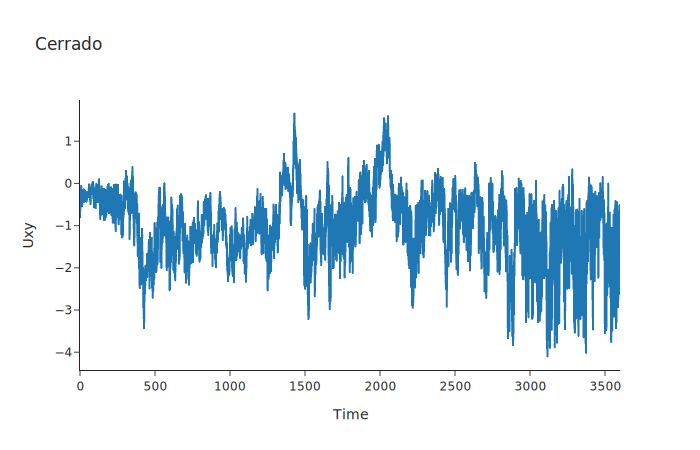

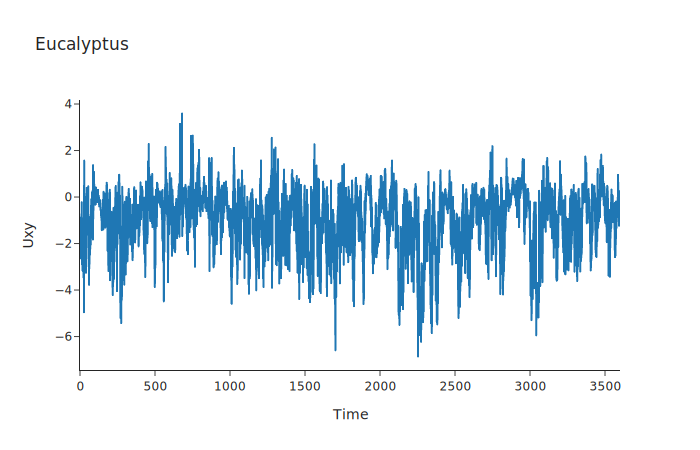

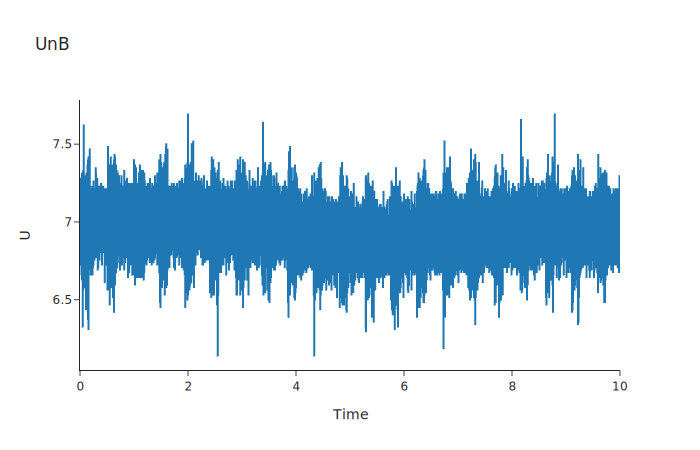

In [14]:
for fig in raw_data_figs:
    raw_data_figs[fig].show()

### Compute for this   wind   speed   the   one-hour   properties   (mean   and variance)

In [15]:
for df_name, df in zip(["Cerrado", "Eucalyptus"], [df_cerrado, df_eucalyptus]):
    print("Mean Uxy for {}: {}".format(df_name, df["Uxy"].mean().round(4)))
    print("Variance Uxy for {}: {}".format(df_name, df["Uxy"].var().round(4)))
    print(" ")
    
for df_name, df in zip(["UnB"], [df_unb]):
    print("Mean U for {}: {}".format(df_name, df["U"].mean().round(4)))
    print("Variance U for {}: {}".format(df_name, df["U"].var().round(4)))
    print(" ")

Mean Uxy for Cerrado: -1.0331
Variance Uxy for Cerrado: 0.6468
 
Mean Uxy for Eucalyptus: -1.0263
Variance Uxy for Eucalyptus: 1.5786
 
Mean U for UnB: 6.9588
Variance U for UnB: 0.0166
 


### Compute the power spectrum for the fluctuating field and plot  the  reference -5/3  decay  close  to  the  inertial  subrange  spectrum region

In [16]:
spectrum_figs = {}

for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):
    
    if df_name == "UnB":
        variable = df["U'"]
        acquisition = 10000
        hz_scale = 15
    else:
        variable = df["Uxy'"]
        acquisition = 10
        hz_scale = 0.05
    
    u_fft = np.fft.fft(variable)

    frequency = (acquisition/2)*np.arange(0,1,1/(len(u_fft)/2))

    spectrum = (abs(u_fft[0:int(len(u_fft)/2)])**2)/len(variable)
    spectrum[0] = 0
    
    df_temp = pd.DataFrame()
    df_temp["-5/3 Decay"] = 0
    df_temp["Frequency"] = frequency
    df_temp["Spectrum"] = spectrum
    for ix, hz in enumerate(frequency):
        if hz > hz_scale:
            df_temp["-5/3 Decay"][ix] = (hz**(-5/3))
    
    
    
    spectrum_figs["{}".format(df_name)] = px.line(df_temp, x="Frequency", y=["Spectrum","-5/3 Decay"], log_x=True, log_y=True, title=df_name, template="simple_white")

    spectrum_figs["{}".format(df_name)].update_layout(
        yaxis = dict(
            showexponent = 'all',
            exponentformat = 'e'
        )
    )

In [17]:
for fig in spectrum_figs:
    spectrum_figs[fig].write_html(fig+".html")

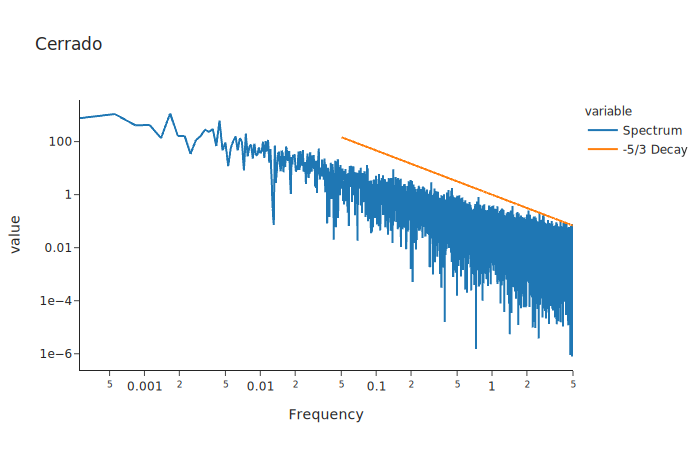

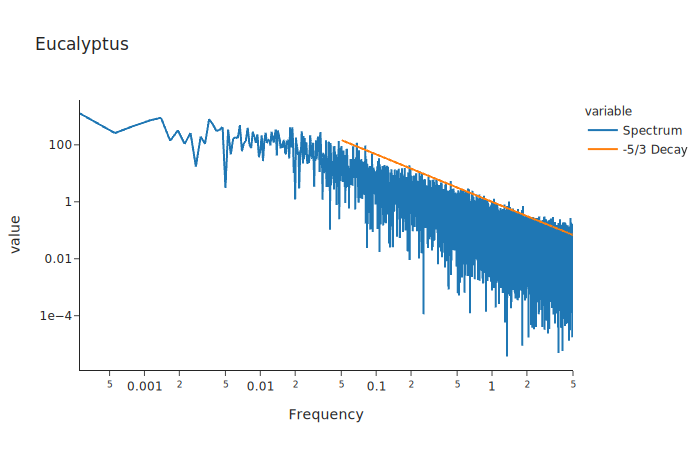

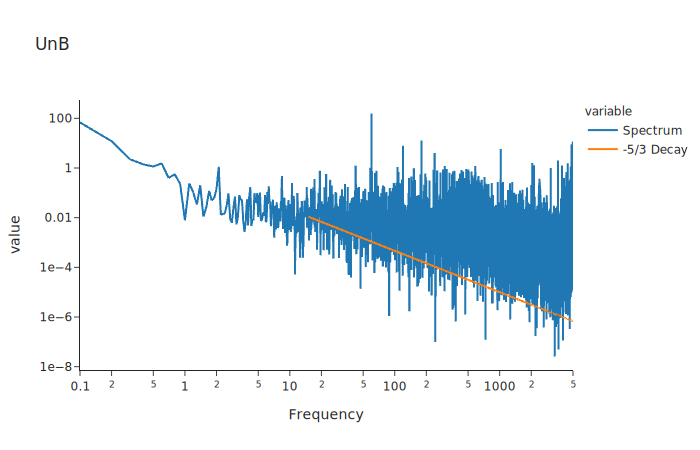

In [18]:
for fig in spectrum_figs:
    spectrum_figs[fig].show()

### Compute the CDF (cumulative distribution function) and PDF (probability distribution function) for this time series. Is the PDF Gaussian?

In [19]:
statistics_figs = {}

for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):
    
    variable 
    
    if df_name == "UnB":
        variable = "U"
    else:
        variable = "Uxy"
        fig_title = "Joint frequency for {}".format(df_name)
        statistics_figs[fig_title] = px.density_contour(df, x="Ux", y="Uy", title=fig_title, marginal_x="histogram", marginal_y="histogram", template="simple_white")

    
    df_cdf = pd.DataFrame()
    df_cdf[variable] = np.sort(df[variable])
    df_cdf["Probability"] = 1. * np.arange(len(df[variable])) / (len(df[variable]) - 1)
    fig_title = "CDF for {}".format(df_name)
    statistics_figs[fig_title] = px.line(df_cdf, x=variable, y="Probability", title=fig_title, template="simple_white")
    
    sample = df[variable].values
    
    if np.min(sample) < 0:  
        df_pdf = pd.DataFrame()
        sample_over = df[variable].values - (np.min(sample)+1)
        shape, loc, scale = s.weibull_min.fit(sample_over, floc=0)
        wei = s.weibull_min(shape, loc, scale) # shape, loc, scale - creates weibull object
        df_pdf[variable] = np.linspace(np.min(sample_over), np.max(sample_over))
        df_pdf["Probability"] = wei.pdf(df_pdf[variable]) 
    else:
        df_pdf = pd.DataFrame()
        sample = df[variable].values
        shape, loc, scale = s.weibull_min.fit(sample, floc=0)
        wei = s.weibull_min(shape, loc, scale) # shape, loc, scale - creates weibull object
        df_pdf[variable] = np.linspace(np.min(sample), np.max(sample))
        df_pdf["Probability"] = wei.pdf(df_pdf[variable])
        
    df_pdf[variable] = np.linspace(np.min(sample), np.max(sample))
    fig_title = "PDF for {}".format(df_name)
    statistics_figs[fig_title] = px.line(df_pdf, x=variable, y="Probability", title=fig_title, template="simple_white")

In [20]:
for fig in statistics_figs:
    statistics_figs[fig].write_html(fig+".html")

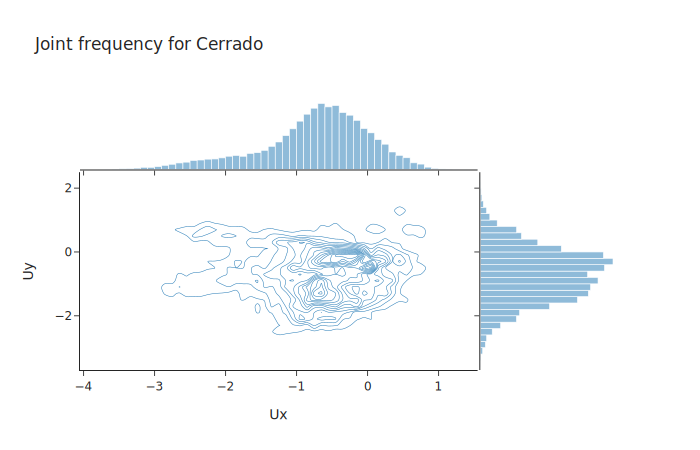

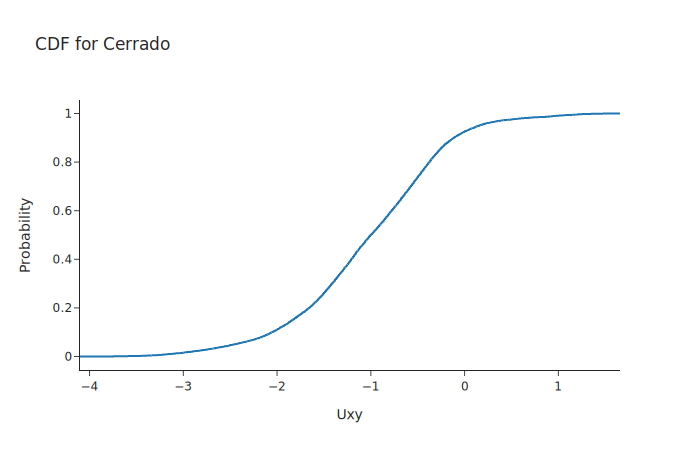

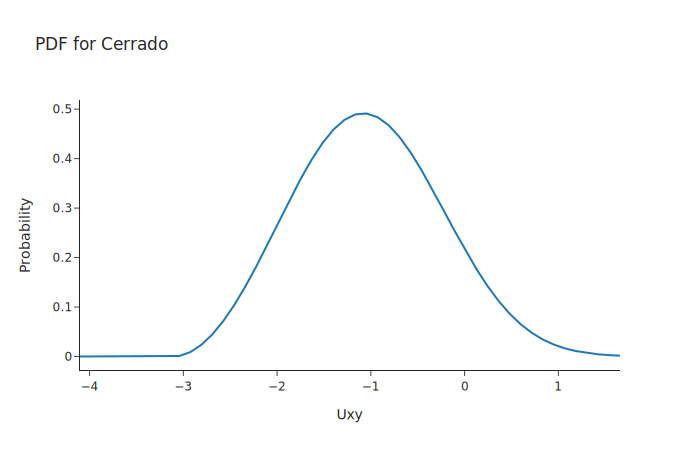

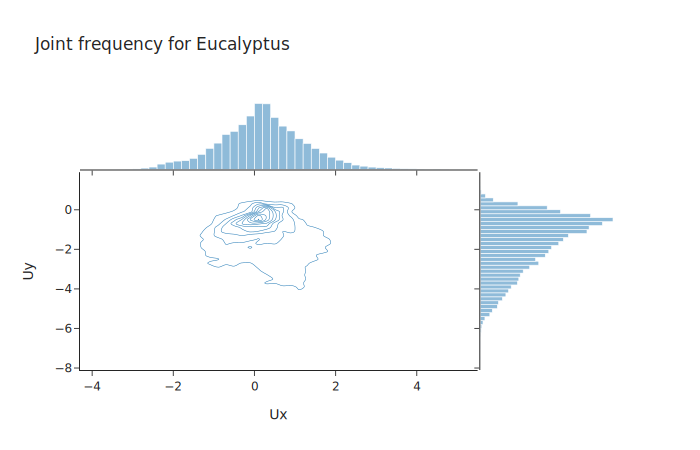

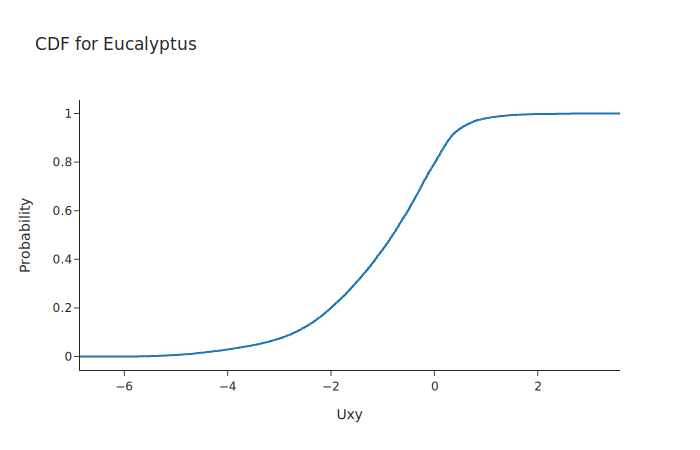

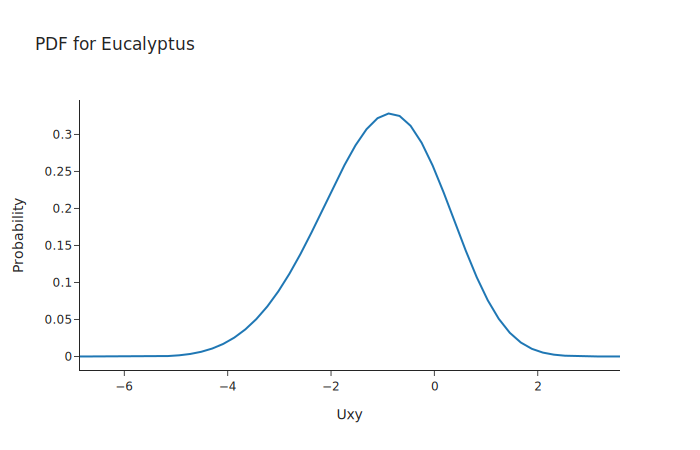

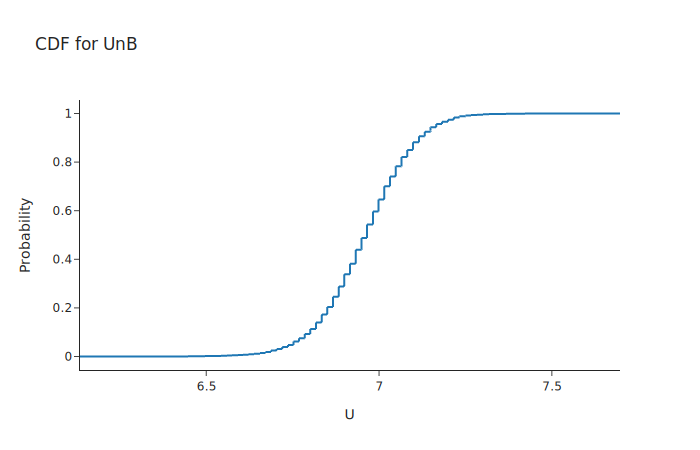

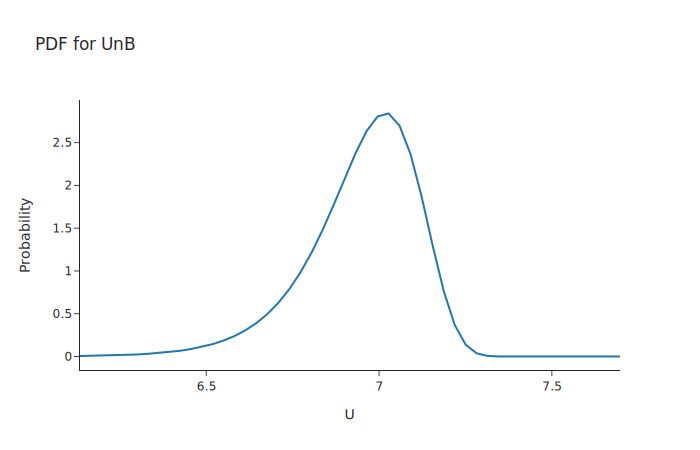

In [21]:
for fig in statistics_figs:
    statistics_figs[fig].show()

### Plot the autocorrelation function for both series

In [22]:
autocorrelation_figs = {}
df_autocorrelation = pd.DataFrame()
lags = 5000
df_autocorrelation["Lags"] = range(lags)

for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):
    
    if df_name == "UnB":
        variable_list = ["U"]
    else:
        variable_list = ["Ux", "Uy"]
    
    for variable in variable_list:
    
        fig_title = "Autocorrelation of {} for {}".format(variable,df_name)
        df_autocorrelation[fig_title] = pd.Series(sm.tsa.acf(df[variable], nlags=lags, fft=False))
        autocorrelation_figs[fig_title] = px.line(df_autocorrelation, x="Lags", y=fig_title, title=fig_title, template="simple_white",
                                 labels={
                                     fig_title : "Autocorrelation"
                                 }
                             )

In [23]:
for fig in autocorrelation_figs:
    autocorrelation_figs[fig].write_html(fig+".html")

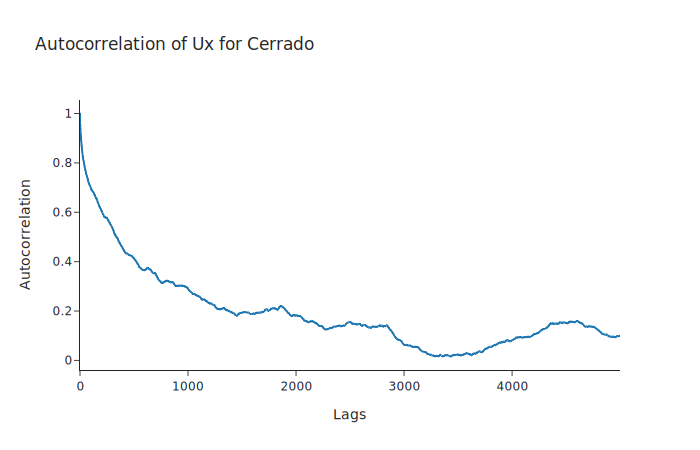

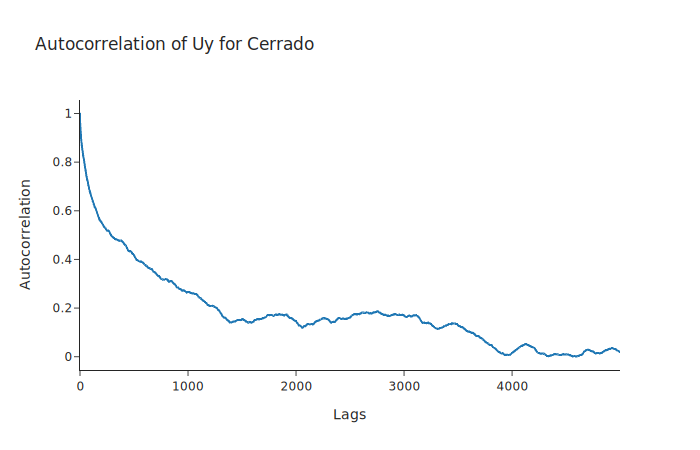

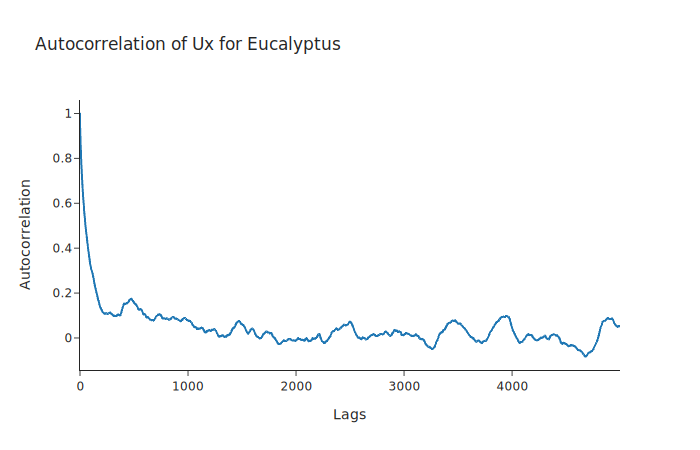

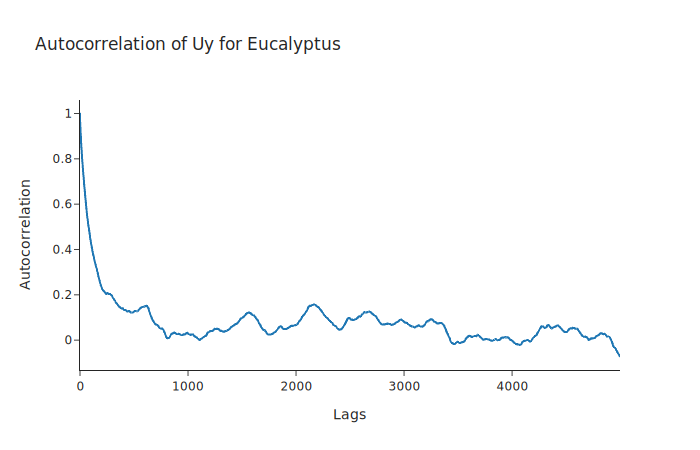

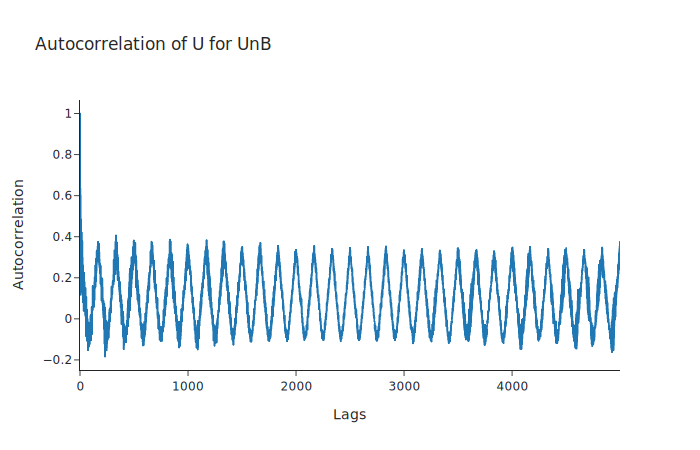

In [24]:
for fig in autocorrelation_figs:
    autocorrelation_figs[fig].show()

### Correlation coefficient between different directions

In [25]:
for df_name, df in zip(["Cerrado", "Eucalyptus"], [df_cerrado, df_eucalyptus]):
    correlation = np.corrcoef(df["Ux"].values.astype("float"),df["Uy"].values.astype("float"))[0,1].round(2)
    
    print("Correlation between Ux and Uy for {}: {}".format(df_name, correlation))
    print(" ")

Correlation between Ux and Uy for Cerrado: 0.01
 
Correlation between Ux and Uy for Eucalyptus: 0.02
 


### Compute the integral time scale from the autororrelation function

In [26]:
print("Integral time scale from the autocorrelation function for:")
print("")

for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):
    
    if df_name == "UnB":
        variable_list = ["U"]
    else:
        variable_list = ["Ux", "Uy"]
    
    for variable in variable_list:
    
        title = "Autocorrelation of {} for {}".format(variable, df_name)
        integral_length_scale = np.trapz(df_autocorrelation[title])
        print("{} for {}: {}".format(variable, df_name, integral_length_scale.round(4)))
        
    print("")

Integral time scale from the autocorrelation function for:

Ux for Cerrado: 976.094
Uy for Cerrado: 910.4651

Ux for Eucalyptus: 224.0466
Uy for Eucalyptus: 384.2764

U for UnB: 501.0959



### Compute  the  integral  length  scale  based  in  the  paper  of  El-Gabry  et  al (2014)  and  compare  it  to  the  value  computed  from  autororrelation function

In [27]:
df_temp = pd.DataFrame()

for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):
    
    print("")
    print("{}".format(df_name))
    print("")
    
    if df_name == "UnB":
        variable_list = [df["U"]]
    else:
        variable_list = [df["Ux"], df["Uy"]]
    
    for variable in variable_list:
        
        hz = 10
        
        u_fft = np.fft.fft(variable-np.mean(variable))
        energy_spectrum = (abs(u_fft[0:int(len(u_fft)/2)])**2)/(len(variable)*hz)
        energy_spectrum[0] = 0
        average_energy_spectrum_start = np.mean(spectrum[0:100])
        
        el_gabry = abs(average_energy_spectrum_start*np.mean(variable))/(4*(np.std(variable)**2))
        
        title = "Autocorrelation of {} for {}".format(variable.name, df_name)
        integral_length_scale = np.trapz(df_autocorrelation[title])
        
        print("El-Gabry length scale ({}): {}".format(variable.name, round(el_gabry,4)))
        print("Autocorrelation length scale ({}): {}".format(variable.name, round(integral_length_scale,4)))
        print("")
   
    print('―' * 10)



Cerrado

El-Gabry length scale (Ux): 0.2859
Autocorrelation length scale (Ux): 976.094

El-Gabry length scale (Uy): 0.2468
Autocorrelation length scale (Uy): 910.4651

――――――――――

Eucalyptus

El-Gabry length scale (Ux): 0.0406
Autocorrelation length scale (Ux): 224.0466

El-Gabry length scale (Uy): 0.1997
Autocorrelation length scale (Uy): 384.2764

――――――――――

UnB

El-Gabry length scale (U): 97.6762
Autocorrelation length scale (U): 501.0959

――――――――――


### Compute the Kolmogorov scales.

In [28]:
for df_name, df in zip(["Cerrado", "Eucalyptus", "UnB"], [df_cerrado, df_eucalyptus, df_unb]):

    print("")
    print("{}".format(df_name))
    print("")
    
    if df_name == "UnB":
        variable_list = [df["U"]]
    else:
        variable_list = [df["Ux"], df["Uy"]]
    
    for variable in variable_list:

        wavenumber = np.mean(0.5*((variable-np.mean(variable))**2))
    
        u_0 = ((2/3)*wavenumber)**(1/2)
        
        title = "Autocorrelation of {} for {}".format(variable.name, df_name)
        integral_length_scale = np.trapz(df_autocorrelation[title])
        u_scaled = (u_0**3)/(integral_length_scale)

        nu_coeff = 1.55*(10**-5)
        eta = (((nu_coeff)**3)/u_scaled)**(1/4)
        vkom = (0.0000172/u_scaled)**(1/2)
        u_eta = (0.0000172*u_scaled)**(1/4)

        print("Komolgorov length scale ({}): {}".format(variable.name,round(eta,4)))
        print("Komolgorov speed scale ({}): {}".format(variable.name,round(vkom,4)))
        print("Komolgorov time scale ({}): {}".format(variable.name,round(u_eta,4)))

        print("")
   
    print('―' * 10)


Cerrado

Komolgorov length scale (Ux): 0.0025
Komolgorov speed scale (Ux): 0.4291
Komolgorov time scale (Ux): 0.0063

Komolgorov length scale (Uy): 0.0024
Komolgorov speed scale (Uy): 0.3842
Komolgorov time scale (Uy): 0.0067

――――――――――

Eucalyptus

Komolgorov length scale (Ux): 0.0014
Komolgorov speed scale (Ux): 0.1268
Komolgorov time scale (Ux): 0.0116

Komolgorov length scale (Uy): 0.0013
Komolgorov speed scale (Uy): 0.1112
Komolgorov time scale (Uy): 0.0124

――――――――――

UnB

Komolgorov length scale (U): 0.0082
Komolgorov speed scale (U): 4.5825
Komolgorov time scale (U): 0.0019

――――――――――
